# IMPLEMENTATION OF THE PAPER  "Rethinking Counting and Localization in Crowds: A Purely Point-Based Framework" #

*Antonio Waraich, Simone Boesso, Eugenio Baldo*

## ABSTRACT ##

Tha aim of our work is to reproduce the results of the paper cited above by using our custom implementation of the paper. We tried to understand the P2P network proposed by the paper by writing from scratch a few parts described in the paper and used or reingeneered other parts taken from the official implementation available at [ TencentYoutuResearch - Github](https://github.com/TencentYoutuResearch/CrowdCounting-P2PNet).

## INTRODUCTION ##

The paper gives a solution for the task of crowd counting and introduces a new approach called the purely point based framework. Crowd counting is the task of counting and localizing people in an image. This is quite relevant because it is linked to many meaningful activities such as crowd tracking, activity recognition, abnormality detection and flow behavior prediction.

## RELATED WORKS ##

The framework proposed by the paper differentiates from previous approaches like bounding boxes and density maps because it gives an exact location of each person instead of using the previous ones which have certain drawbacks such as overlapping.
The current state of the art methods can be viewed at [papers with code](https://paperswithcode.com/task/crowd-counting), where it's reported the ranking for each different dataset according to different metrics. 
It is possible to observe that the current state of the art methods are based on: 
1.   CNN architectures (vgg, resnet...) such as our paper
2.   attention mechanism 
3.   a mix of the above approaches

However only the P2P network uses a purely point based approach in order to provide people's localization, whereas the other state of the art models use mainly density maps and bounding boxes.



## PROPOSED METHOD EXPLAINED ##

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/final_project

/content/drive/MyDrive/final_project


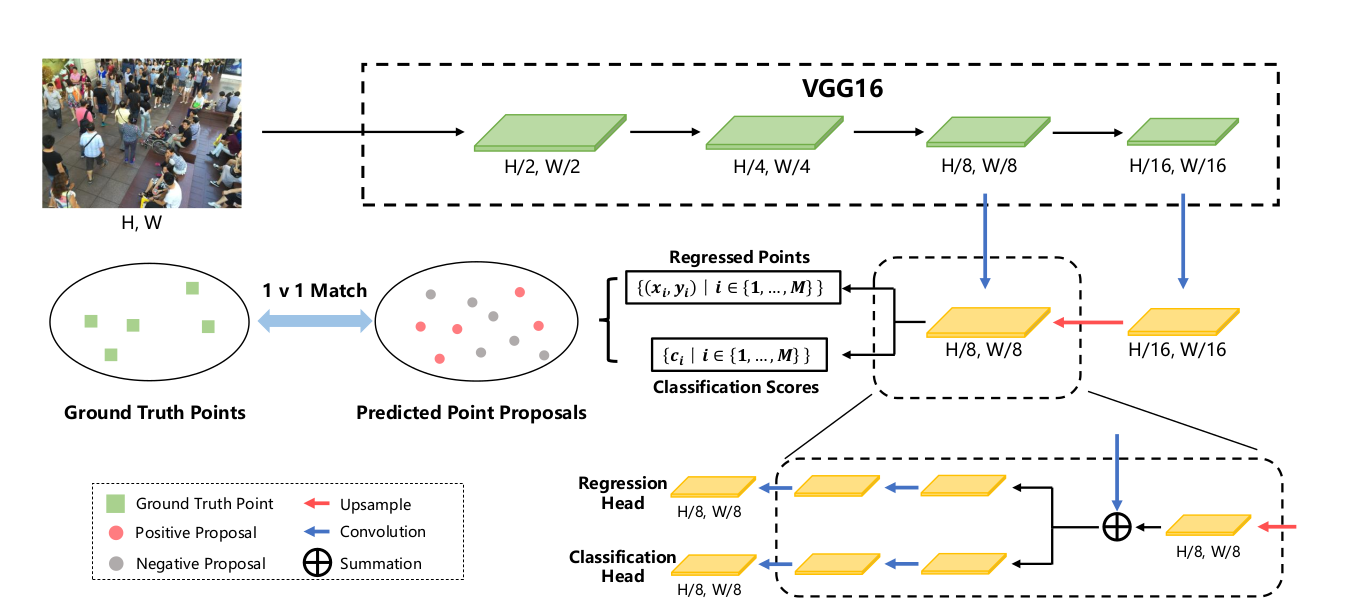

In [3]:
from PIL import Image

img=Image.open('model.png')
img

The proposed model is structured in this way:

1.   A backbone model which is a VGG16-BN pretrained on ImageNet1K, which is responsible to extract the feature maps from the input image
2.   A decoder part which is composed by one or more upsamples layer from the final feature map and/or lateral connections. The features maps coming from lateral connections are firstly passed to two additional cnn layers and then added elementwise to the final feature map resulting from the backbone. The structure of this part is very similar to the one adopted in the ResNet.
3. Given the generated feature map as explained above, the model sets the reference points coordinates(x,y) on the original image, then using a regression head, it find the offsets from the reference points to get the final coordinates on the image.
4. For each pair of coordinates, The model uses a separate classification head in order to assign a confidence score which represents the probability that the predicted point is a true positive. 
During testing, if the the confidence score is greater than the threshold(0.5) then the predicted point is accepted, otherwise is discarded.
5. During Training,provided that one prediction may be associated with different ground truths points and viceversa, the model implements a one-to-one matching using the Hungarian algorithm.
6. The loss used to optimize the model is composed by two different losses. The first is the Crossentropy Loss computed on the confidence scores. The second is the Euclidean distance between the predicted points and the ground truth points.

## DATASET AND BENCHMARK ##

Our implementation will be tested on two different datasets. 


1.   Shanghai dataset, part A. The dataset contains 300 training images and 182 test images of congested places. The images are taken in different scenes and they are very different from each other. For this dataset,  The current performance ranking on this dataset is available at:
[papers with code](https://paperswithcode.com/sota/crowd-counting-on-shanghaitech-a).
It is observable that the P2Pnet is the best performing model until now on this dataset.

2. MALL dataset. The dataset contains 2000 images taken from the same camera in a shopping center. Differently from before, the scene is always the same. This dataset has not been used by the researchers to train and test the model. We decided to use 1400 images for the training and the others for validation. The current performance ranking for other models on this dataset is available at [papers with code](https://paperswithcode.com/dataset/mall).


In [4]:
!pwd

/content/drive/MyDrive/final_project


importing libraries

In [5]:
import torch
from backbone.backbone import BackboneModel
import numpy as np
from torch.utils.data import DataLoader
from PIL import Image
from torchvision.utils import draw_keypoints
import matplotlib.pyplot as plt
from branches import regressor
from branches import classifier
from P2Pnet import P2P
from torch.optim import Adam
from matcher import *
import os
from scipy.special import softmax
from typing import List
from torch import Tensor

In [6]:
#seeds for reproducibility
torch.manual_seed(1234)
np.random.seed(1234)

here we choose if in the current run we want to use the Shanghai dataset or the MAll dataset

In [7]:
mall=True

if mall:
  from dataset_utils_mall import loading_data
  from dataset_utils_mall import *

else:
  from dataset_utils import *
  from dataset_utils import loading_data

check if gpu is available

In [8]:
if not torch.cuda.is_available():
    device = torch.device("cpu")
    print("Current device:", device)
else:
    device = torch.device("cuda")
    print("Current device:", device, "- Type:", torch.cuda.get_device_name(0))

Current device: cuda - Type: Tesla T4


transformation functions

In [9]:
def nested_tensor_from_tensor_list(tensor_list: List[Tensor]):
    # TODO make this more general
    if tensor_list[0].ndim == 3:

        # TODO make it support different-sized images
        max_size = _max_by_axis_pad([list(img.shape) for img in tensor_list])
        # min_size = tuple(min(s) for s in zip(*[img.shape for img in tensor_list]))
        batch_shape = [len(tensor_list)] + max_size
        b, c, h, w = batch_shape
        dtype = tensor_list[0].dtype
        device = tensor_list[0].device
        tensor = torch.zeros(batch_shape, dtype=dtype, device=device)
        for img, pad_img in zip(tensor_list, tensor):
            pad_img[: img.shape[0], : img.shape[1], : img.shape[2]].copy_(img)
    else:
        raise ValueError('not supported')
    return tensor

def _max_by_axis_pad(the_list):
    # type: (List[List[int]]) -> List[int]
    maxes = the_list[0]
    for sublist in the_list[1:]:
        for index, item in enumerate(sublist):
            maxes[index] = max(maxes[index], item)

    block = 128

    for i in range(2):
        maxes[i+1] = ((maxes[i+1] - 1) // block + 1) * block
    return maxes

dataset creation

In [10]:
if mall==False:
  train_dataset, val_dataset = loading_data('datasets/ShanghaiTech/part_A/')
  
else:
  train_dataset, val_dataset = loading_data(os.path.join(os.getcwd(),'datasets/mall_dataset/mall_dataset/'))

print('length of the train dataset:', len(train_dataset))
print('length of the test dataset:', len(val_dataset))

length of the train dataset: 1400
length of the test dataset: 600


data loader creation

In [11]:
#custom collate function

def collate_fn_crowd(batch):
    # re-organize the batch
    batch_new = []
    for b in batch:
        imgs, points = b
        if imgs.ndim == 3:
            imgs = imgs.unsqueeze(0)
        for i in range(len(imgs)):
            batch_new.append((imgs[i, :, :, :], points[i]))
    batch = batch_new
    batch = list(zip(*batch))
    batch[0] = nested_tensor_from_tensor_list(batch[0])
    return tuple(batch)

sampler_train = torch.utils.data.RandomSampler(train_dataset)
sampler_val = torch.utils.data.SequentialSampler(val_dataset)

batch_sampler_train = torch.utils.data.BatchSampler(sampler_train, 8, drop_last=True)
# the dataloader for training
train_dl = DataLoader(train_dataset, batch_sampler=batch_sampler_train,
                                   collate_fn=collate_fn_crowd)
#the dataloader for validation
val_dl = DataLoader(val_dataset, 1, sampler=sampler_val,
                                    drop_last=False, collate_fn=collate_fn_crowd)

model instation

In [12]:
matcher = HungarianMatcher_Crowd() #instantiate the matcher
model=P2P().to(device) #instatiate the model

#optimizer with different learning rates

optim=Adam([{'params': model.net[0].parameters(),'lr':1e-5},{'params':model.net[1].parameters(),'lr':1e-4},{'params':model.net[2].parameters(),'lr':1e-4}],weight_decay=1e-5)

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

gpu monitoring

In [13]:
torch.cuda.empty_cache() #free cache

In [14]:
!nvidia-smi

Wed Dec 28 16:31:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    29W /  70W |    676MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [15]:
try:
  os.mkdir(os.path.join(os.getcwd(),'checkpoint_model_shanghai'))
except OSError as e:
  print('already created')

already created


In [16]:
try:
  os.mkdir(os.path.join(os.getcwd(),'checkpoint_model_mall'))
except OSError as e:
  print('already created')

already created


In [17]:
start_epoch=1

load a pre-trained model(skip if you want to train from scratch)

In [18]:
'''
load_dir=os.path.join(os.getcwd(),'checkpoint_model_shanghai')
#take the last checkpoint
file_path='50.pth'

checkpoint_path=os.path.join(load_dir,file_path)

model.load_state_dict(torch.load(checkpoint_path))
'''

"\nload_dir=os.path.join(os.getcwd(),'checkpoint_model_shanghai')\n#take the last checkpoint\nfile_path='50.pth'\n\ncheckpoint_path=os.path.join(load_dir,file_path)\n\nmodel.load_state_dict(torch.load(checkpoint_path))\n"

In [19]:
'''
#fix the starting epoch

start_epoch=''

for char in file_path:

  if char.isdigit()==True:

    start_epoch=start_epoch+char


start_epoch=int(start_epoch)+1
print(start_epoch)
'''

"\n#fix the starting epoch\n\nstart_epoch=''\n\nfor char in file_path:\n\n  if char.isdigit()==True:\n\n    start_epoch=start_epoch+char\n\n\nstart_epoch=int(start_epoch)+1\nprint(start_epoch)\n"

weight and biases for monitoring

In [20]:
!pip install wandb -q

     |████████████████████████████████| 1.9 MB 37.8 MB/s 
     |████████████████████████████████| 182 kB 65.7 MB/s 
     |████████████████████████████████| 174 kB 69.4 MB/s 
     |████████████████████████████████| 62 kB 1.5 MB/s 
     |████████████████████████████████| 173 kB 76.2 MB/s 
     |████████████████████████████████| 168 kB 78.2 MB/s 
     |████████████████████████████████| 168 kB 73.6 MB/s 
     |████████████████████████████████| 166 kB 71.9 MB/s 
     |████████████████████████████████| 166 kB 77.9 MB/s 
     |████████████████████████████████| 162 kB 75.7 MB/s 
     |████████████████████████████████| 162 kB 74.4 MB/s 
     |████████████████████████████████| 158 kB 72.9 MB/s 
     |████████████████████████████████| 157 kB 51.1 MB/s 
     |████████████████████████████████| 157 kB 60.1 MB/s 
     |████████████████████████████████| 157 kB 77.3 MB/s 
     |████████████████████████████████| 157 kB 80.3 MB/s 
     |████████████████████████████████| 157 kB 72.9 MB/s 
     |██████████

In [22]:
import wandb

wandb.init(project='aml_progetto_mall')

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


training and evaluation

In [23]:
max_epoch = start_epoch+10
ckp_save_step=1

maes_train = []
mses_train = []
maes_val = []
mses_val = []

wandb.watch(model, log='all',log_freq=1)

if mall:
  print('TRAINING ON MALL')
else:
  print('TRAINING ON SHANGHAI')

for i in range(start_epoch,max_epoch):
    print('current epoch ', i)
    model.train()

    train_loss=0
    val_loss=0
    
    
    train_maes = []
    val_maes = []
    
    train_mses =[]
    val_mses = []
    
    
    
    for idb, batch in enumerate(train_dl):
        optim.zero_grad()

        img, gt = batch  
        x = img.to(device)
        finalcoord, out_c=model(x, train=True)

        outputs = {'pred_logits': out_c, 'pred_points': finalcoord}
        targets = [{k: v.to(device) for k, v in t.items()} for t in gt]
        matching = matcher(outputs, targets)

        outputs_scores = F.softmax(outputs['pred_logits'], -1)[:, :, 1][0] #REVIEW
      
        gt_cnt = targets[0]['point'].shape[0] # REVIEW

        threshold = 0.5

        predict_cnt = int((outputs_scores > threshold).sum())

        train_mae = abs(predict_cnt - gt_cnt)
        train_mse = (predict_cnt - gt_cnt) * (predict_cnt - gt_cnt)
        train_maes.append(float(train_mae))
        train_mses.append(float(train_mse))
        
        loss = computeLoss(matching, outputs, targets, lambda2=2e-4,lambda1=0.5)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(),0.1) #as in the papaer
        optim.step()
        train_loss += loss
    #print('train',outputs_scores.size())
    if i % 1 == 0 and i != 0:
        
        train_mae = np.mean(train_maes)
        train_mse = np.sqrt(np.mean(train_mses))
        
        maes_train.append(train_mae) #memorize the value
        mses_train.append(train_mse)
        # print the results
        print("TRAIN | mae:", train_mae, "mse:", train_mse, "best mae:", np.min(maes_train))
        
    print(f'train loss for epoch {i} is {train_loss}')

  ##VALIDATION

    
 
    for idb, batch in enumerate(val_dl):
        
      with torch.no_grad():

        img, gt = batch  
        x = img.to(device)
        finalcoord_test, out_c_test=model(x, train=False)

        outputs_test = {'pred_logits': out_c_test, 'pred_points': finalcoord_test}
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in gt]
        
        matching = matcher(outputs_test, targets)

        outputs_scores_test = F.softmax(outputs_test['pred_logits'], -1)[:, :, 1][0] 

        gt_cnt = targets[0]['point'].shape[0] 

        threshold = 0.5

        predict_cnt = int((outputs_scores_test > threshold).sum())

        val_mae = abs(predict_cnt - gt_cnt)
        
        val_mse = (predict_cnt - gt_cnt) * (predict_cnt - gt_cnt)
        val_maes.append(float(val_mae))
        val_mses.append(float(val_mse))
        
        loss = computeLoss(matching, outputs_test, targets, lambda2=2e-4,lambda1=0.5)
        val_loss += loss

    #print('prova',test_maes)   
    if i % 1 == 0 and i != 0:
        
        
      val_mae = np.mean(val_maes)
      val_mse = np.sqrt(np.mean(val_mses))
        
      maes_val.append(val_mae)
      mses_val.append(val_mse)
      # print the results
      print("VAL | mae:", val_mae, "mse:", val_mse, "best mae:", np.min(maes_val))
        
  
    print(f'val loss for epoch {i} is {val_loss}')

    

    wandb.log({'train_loss':train_loss, 'val_loss':val_loss,'train_mae':train_mae,'train_mse':train_mse,'val_mae':val_mae,'val_mse':val_mse})
    
    if (i % (ckp_save_step) == 0):

      if mall==True:
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'/content/drive/MyDrive/final_project/checkpoint_model_mall/{(i)}.pth')
      else:
        print("Saving checkpoint... \n ")
        torch.save(model.state_dict(), f'/content/drive/MyDrive/final_project/checkpoint_model_shanghai/{(i)}.pth')



TRAINING ON MALL
current epoch  1


/usr/local/lib/python3.8/dist-packages/torch/nn/functional.py:4070: UserWarning: nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample_bilinear is deprecated. Use nn.functional.interpolate instead.")
/content/drive/MyDrive/final_project/matcher.py:126: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  anchorPoints = torch.tensor(anchorPoints, dtype=torch.float32).to(device)


TRAIN | mae: 8.445714285714285 mse: 51.572750279857786 best mae: 8.445714285714285
train loss for epoch 1 is 6.148685455322266
VAL | mae: 33.29666666666667 mse: 33.77617503507465 best mae: 33.29666666666667
val loss for epoch 1 is 4.798480033874512
Saving checkpoint... 
 
current epoch  2
TRAIN | mae: 1.92 mse: 2.7318230438403477 best mae: 1.92
train loss for epoch 2 is 1.6820567846298218
VAL | mae: 7.656666666666666 mse: 9.053912598061311 best mae: 7.656666666666666
val loss for epoch 2 is 5.165467739105225
Saving checkpoint... 
 
current epoch  3
TRAIN | mae: 0.92 mse: 1.5137465347370977 best mae: 0.92
train loss for epoch 3 is 1.4151344299316406
VAL | mae: 4.12 mse: 5.11207720338155 best mae: 4.12
val loss for epoch 3 is 4.616525650024414
Saving checkpoint... 
 
current epoch  4
TRAIN | mae: 0.7485714285714286 mse: 1.1686377906410035 best mae: 0.7485714285714286
train loss for epoch 4 is 1.2401599884033203
VAL | mae: 8.488333333333333 mse: 9.527416578835348 best mae: 4.12
val loss f

visualization of the predictions on a test image in the current run

In [24]:
counter=0
stop=4#to select a specific image
for test_images, test_labels in val_dl: 
  img_test=test_images[0].to(device)
  gt_test=test_labels[0] 
  if counter==stop:
    break
  counter+=1
img_test=img_test.unsqueeze(0)

In [25]:
model.eval()

points,logits=model(img_test,train=False)

points=points.squeeze(0).cpu().detach().numpy()
logits=logits.squeeze(0).cpu().detach().numpy()

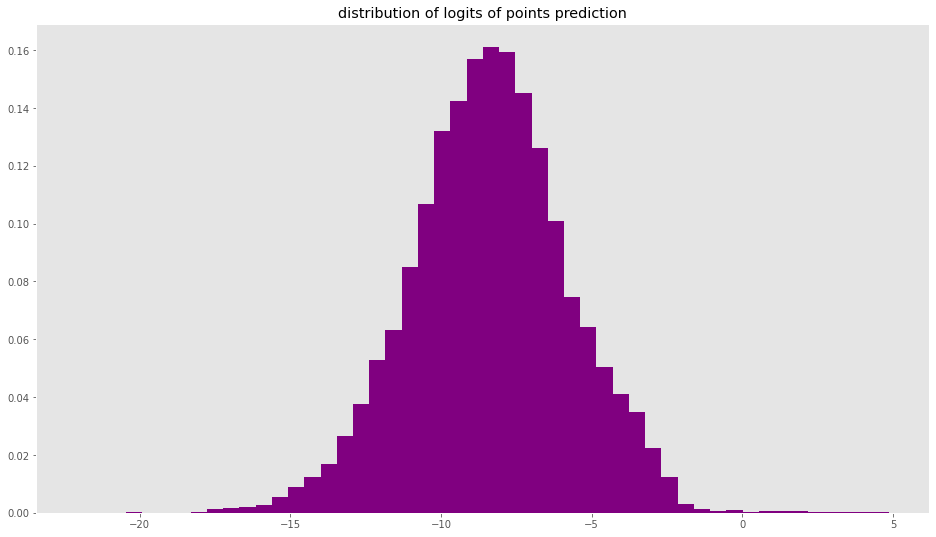

In [26]:
plt.style.use('ggplot')
plt.figure(figsize=(16,9))
plt.title('distribution of logits of points prediction')
plt.hist(logits[:,1],bins=50,density=True,color='purple')
plt.grid()
plt.show()

In [27]:
probs=softmax(logits,axis=1)

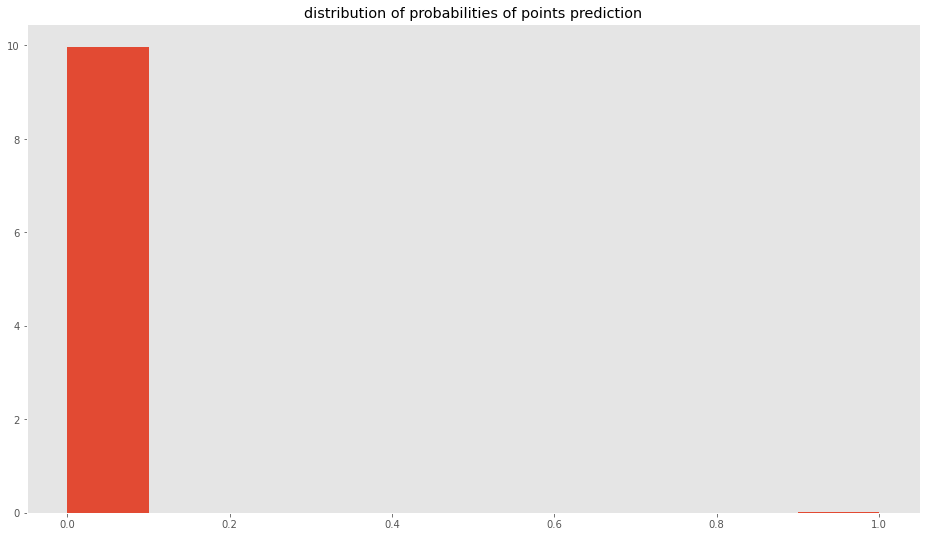

In [28]:
plt.style.use('ggplot')
plt.figure(figsize=(16,9))
plt.title('distribution of probabilities of points prediction')
plt.hist(probs[:,1],density=True)
plt.grid()
plt.show()

As expected the majority of the points in the grid have a low probaility so they won't be accepted as prediction, whereas a few points have a probability greater than 0.5, so they will be included in our prediction set

we set the threshold to 0.5. if the probability is greater than the threshold then we accept the prediction, otherwise we refuse it

In [29]:
threshold=0.5

In [30]:
pred_points=[]
for idx,point in enumerate(points):

  probability_prediction=probs[idx,1]

  if probability_prediction >=threshold:

    pred_points.append(points[idx])

pred_points=np.array(pred_points)

print(pred_points.shape)

(40, 2)


In [31]:
dataset='mall'

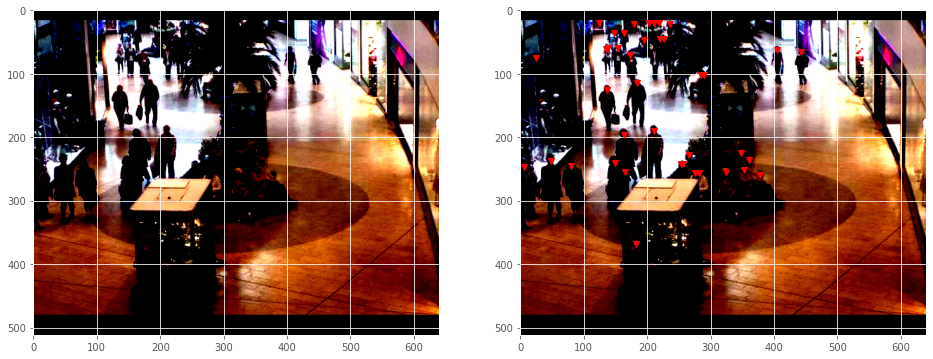

In [32]:
fig,ax=plt.subplots(1,2,figsize=(16,9))

img=img_test.squeeze(0).permute(1, 2, 0).cpu().numpy()

for i in range(pred_points.shape[0]):

  ax[1].plot(pred_points[i,0],pred_points[i,1],marker='v',color='red')

ax[0].imshow(img)
ax[1].imshow(img)
plt.savefig(f'points_predictions_{dataset}_{stop}.png')
plt.show()

In [33]:
number_people_gt=len(gt_test['point'])
print('true number of people is:',number_people_gt)

true number of people is: 35


In [34]:
number_people_pred=pred_points.shape[0]
print('predicted number of people is:', number_people_pred)

predicted number of people is: 40


### EVALUATION AND RESULTS ###

In [35]:
import pandas as pd

####  results using the hyperparameters suggested by the paper ####

**MALL**

**plots**

here we display 3 plots for the MALL dataset:


1.   loss and metrics for training and validation
2.   gradients for a few layers
3.   feature maps for a few layers



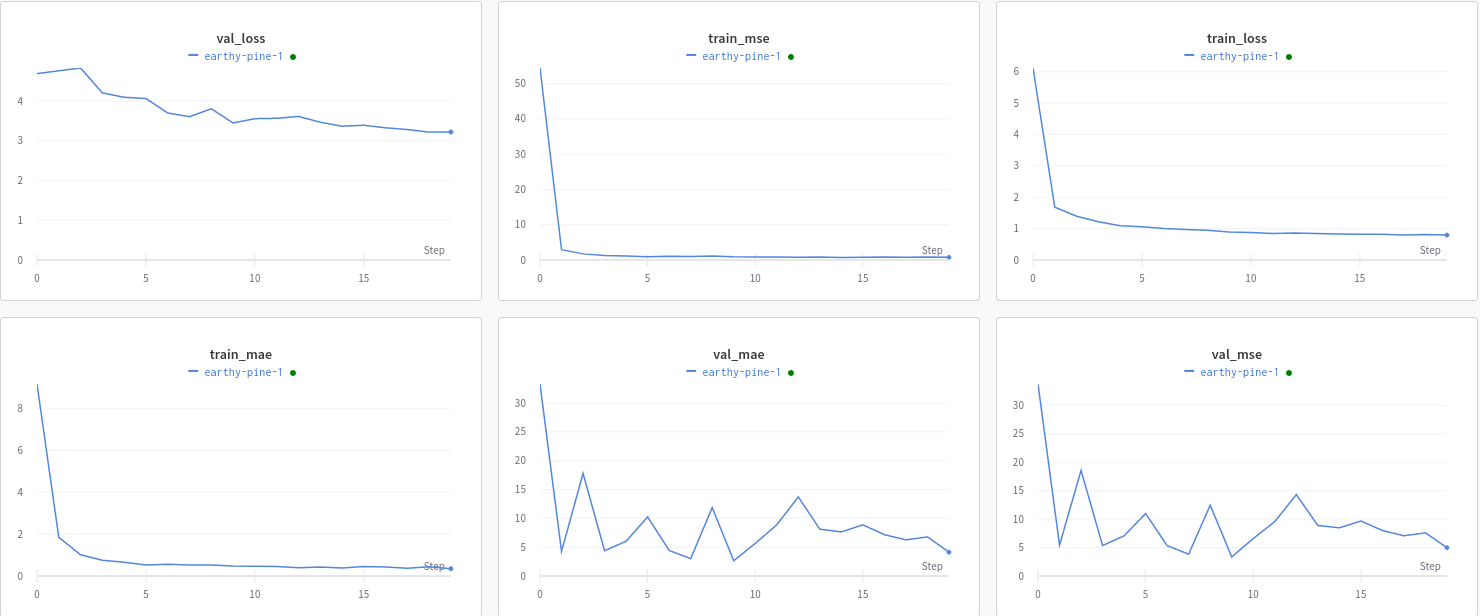

In [36]:
path=os.path.join(os.getcwd(),'plots_mall','loss_metrics.png')
img=Image.open(path)
img

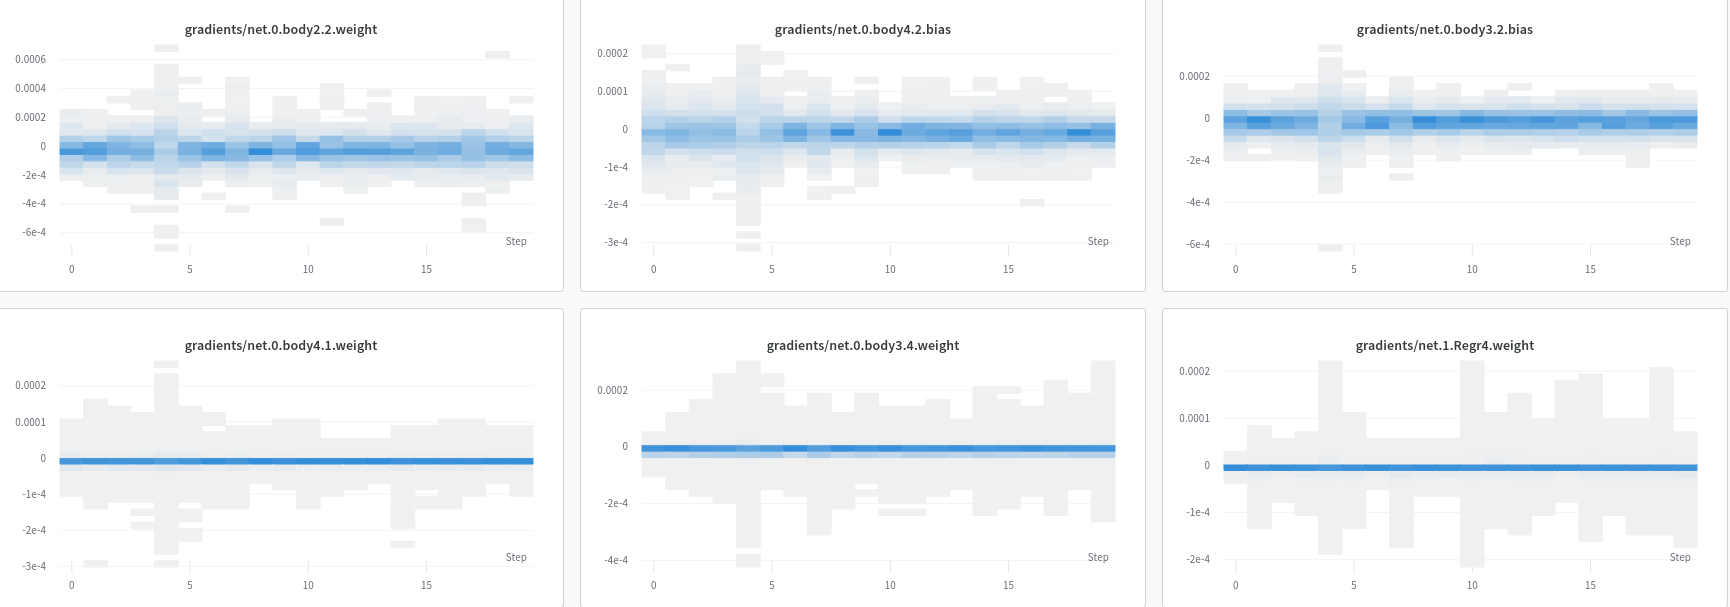

In [37]:
path=os.path.join(os.getcwd(),'plots_mall','gradients.png')
img=Image.open(path)
img

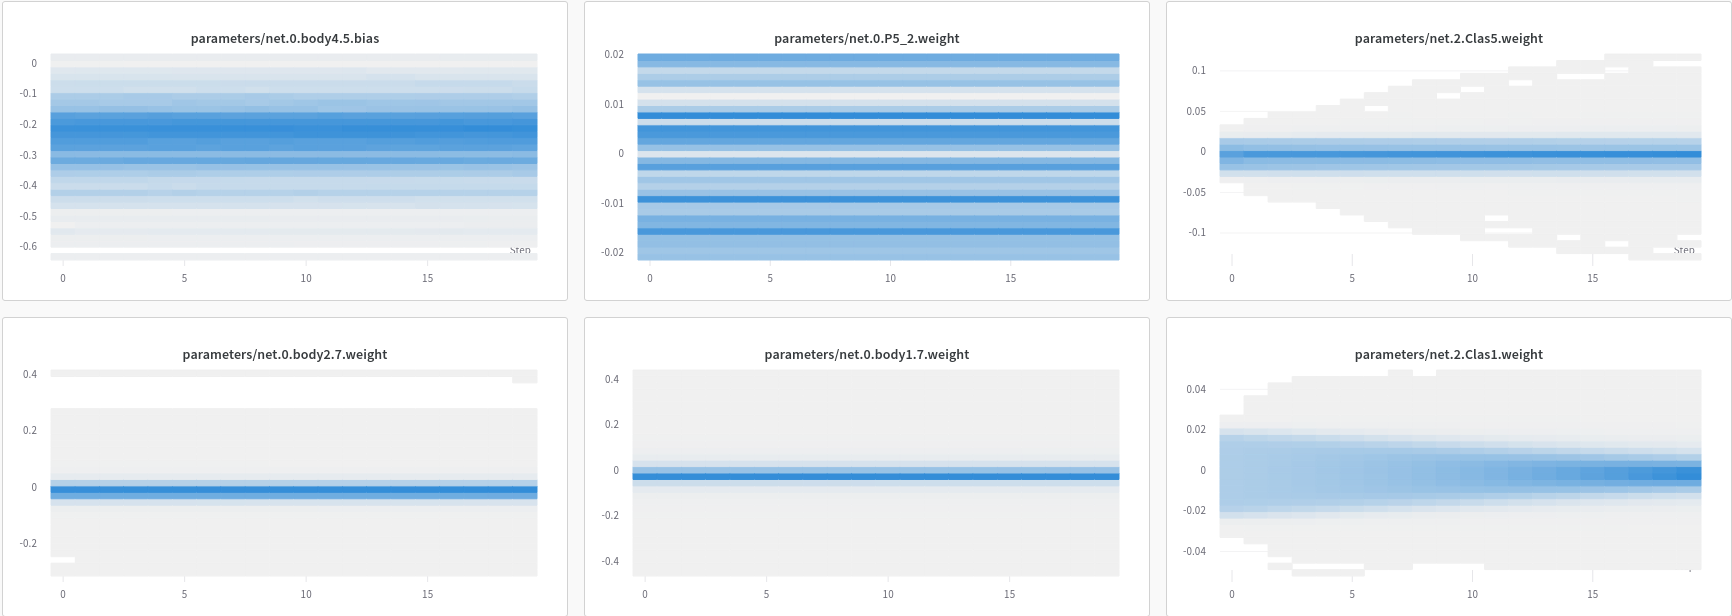

In [38]:
path=os.path.join(os.getcwd(),'plots_mall','feature_maps.png')
img=Image.open(path)
img

we can observe from the gradients and feature maps that the gradients are still significant and not vanishing along the epochs and therefore  parameters tend still to change at the end of the training. Therefore, it would be still possible to decrease the training loss and metrics. However, this is not ensured for the validation, because at a certain point it may be start overfitting.

**summary table after 20 epochs for the best model according to validation MAE**

In [39]:
dict_summary={'train loss':[0.7939],'train mae':[0.3486],'train mse':[0.7521],'val loss':[3.222],'val mae':[2.64],'val mse':[3.36]}
pd.DataFrame(dict_summary)

,train loss,train mae,train mse,val loss,val mae,val mse
0,0.7939,0.3486,0.7521,3.222,2.64,3.36


**qualitative results on images taken from the validation set**

here we show the predictions on specific test images to show the behavior of the model. On the left, there is the original image, whereas on the right, there is the image provided with model predictions.

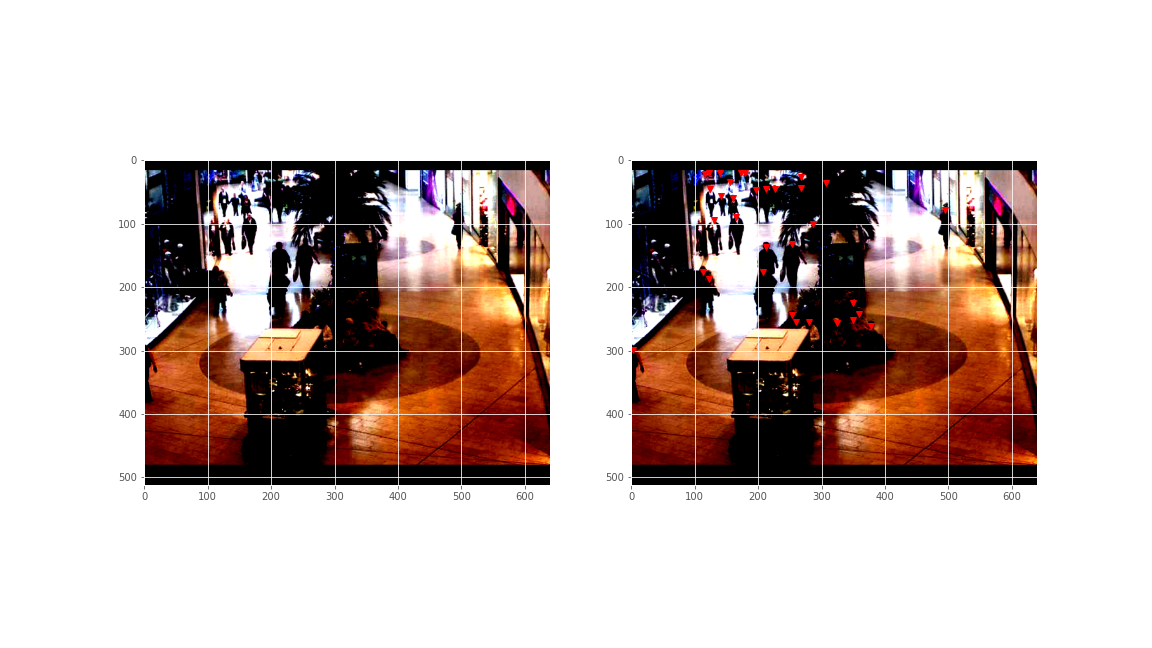

In [40]:
indexes=[1,10,100,150]
path=os.path.join(os.getcwd(),'plots_mall',f'points_predictions_mall_{indexes[0]}.png')
img=Image.open(path)
img

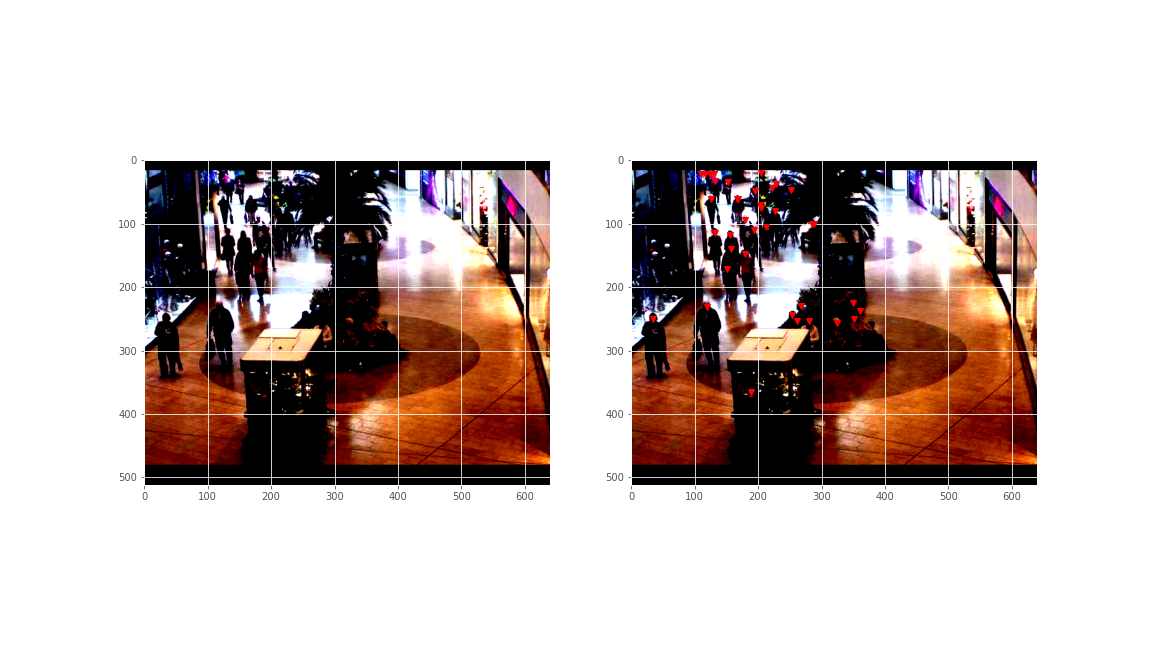

In [41]:
path=os.path.join(os.getcwd(),'plots_mall',f'points_predictions_mall_{indexes[1]}.png')
img=Image.open(path)
img

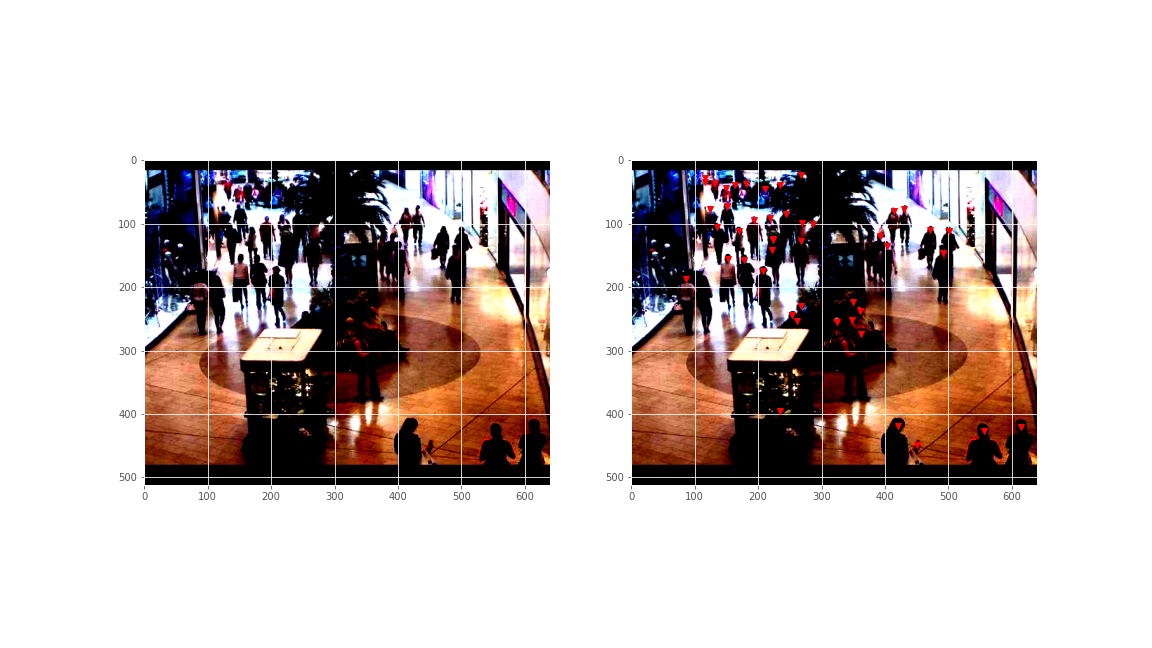

In [42]:
path=os.path.join(os.getcwd(),'plots_mall',f'points_predictions_mall_{indexes[2]}.png')
img=Image.open(path)
img

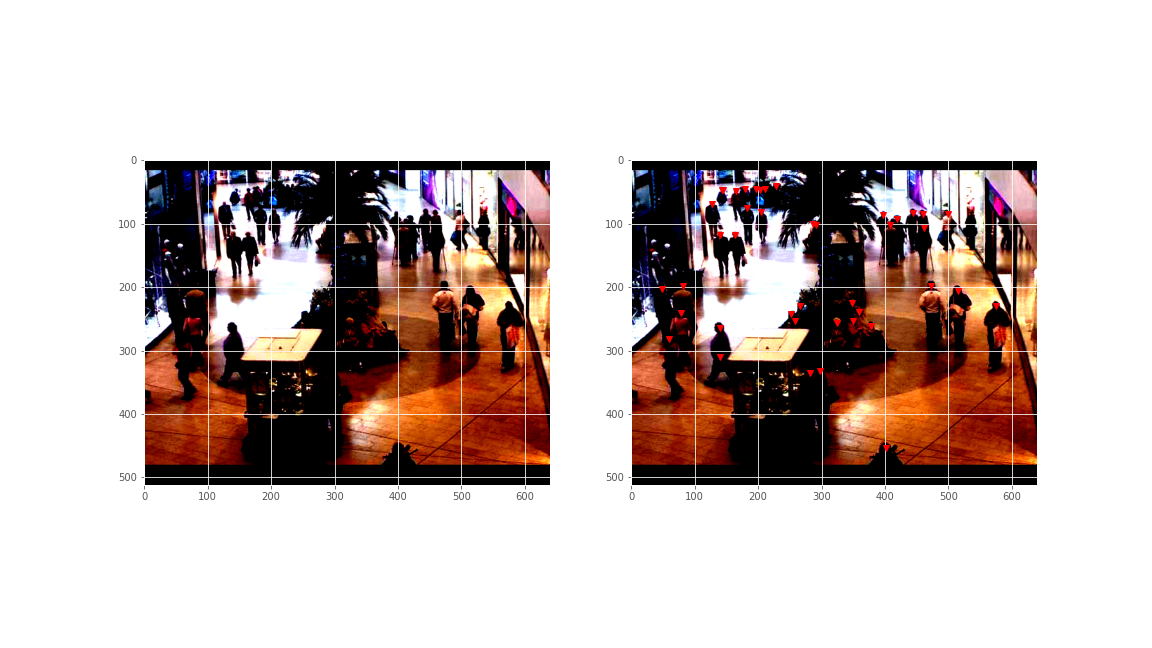

In [43]:
path=os.path.join(os.getcwd(),'plots_mall',f'points_predictions_mall_{indexes[3]}.png')
img=Image.open(path)
img

**SHANGHAI**

**plots**

here we display 3 plots for the Shanghai dataset:


1.   loss and metrics for training and validation
2.   gradients for a few layers
3.   feature maps for a few layers


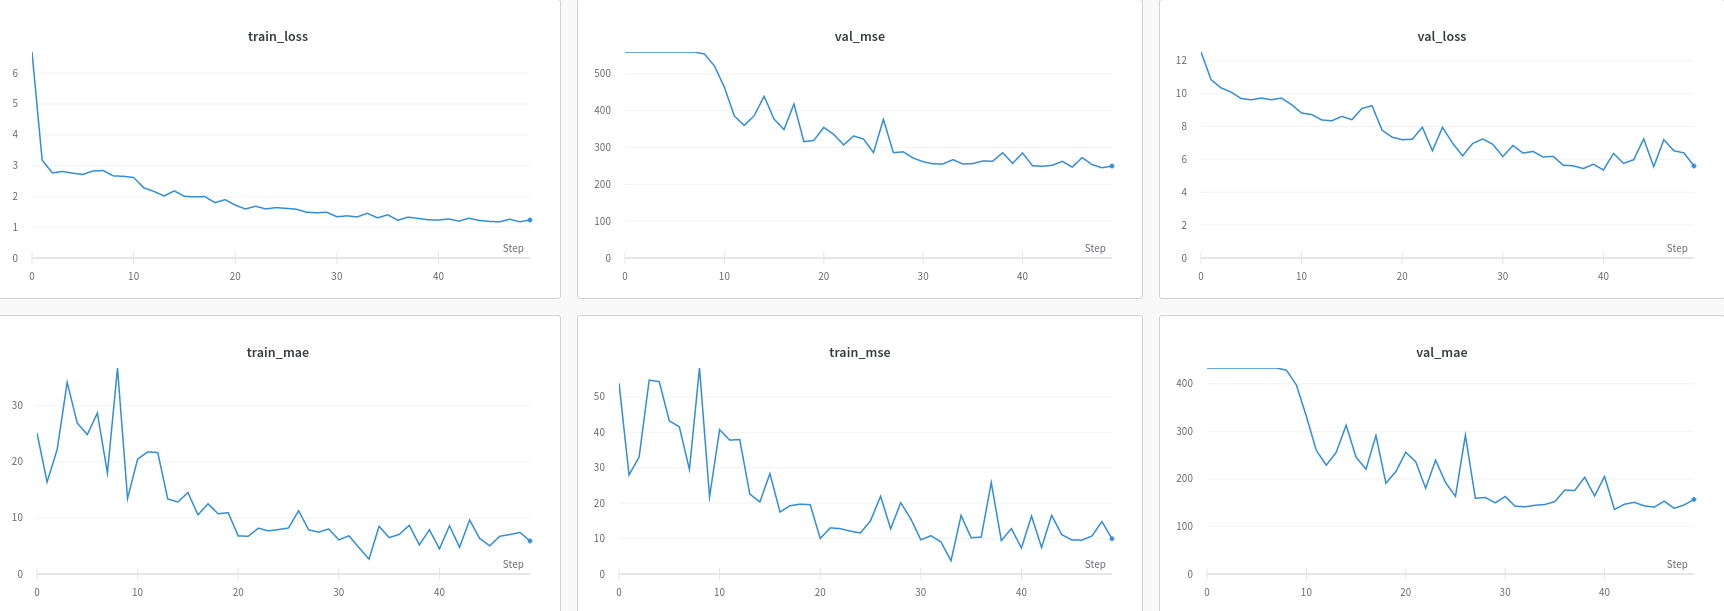

In [44]:
path=os.path.join(os.getcwd(),'plots_shanghai','loss_metrics.png')
img=Image.open(path)
img

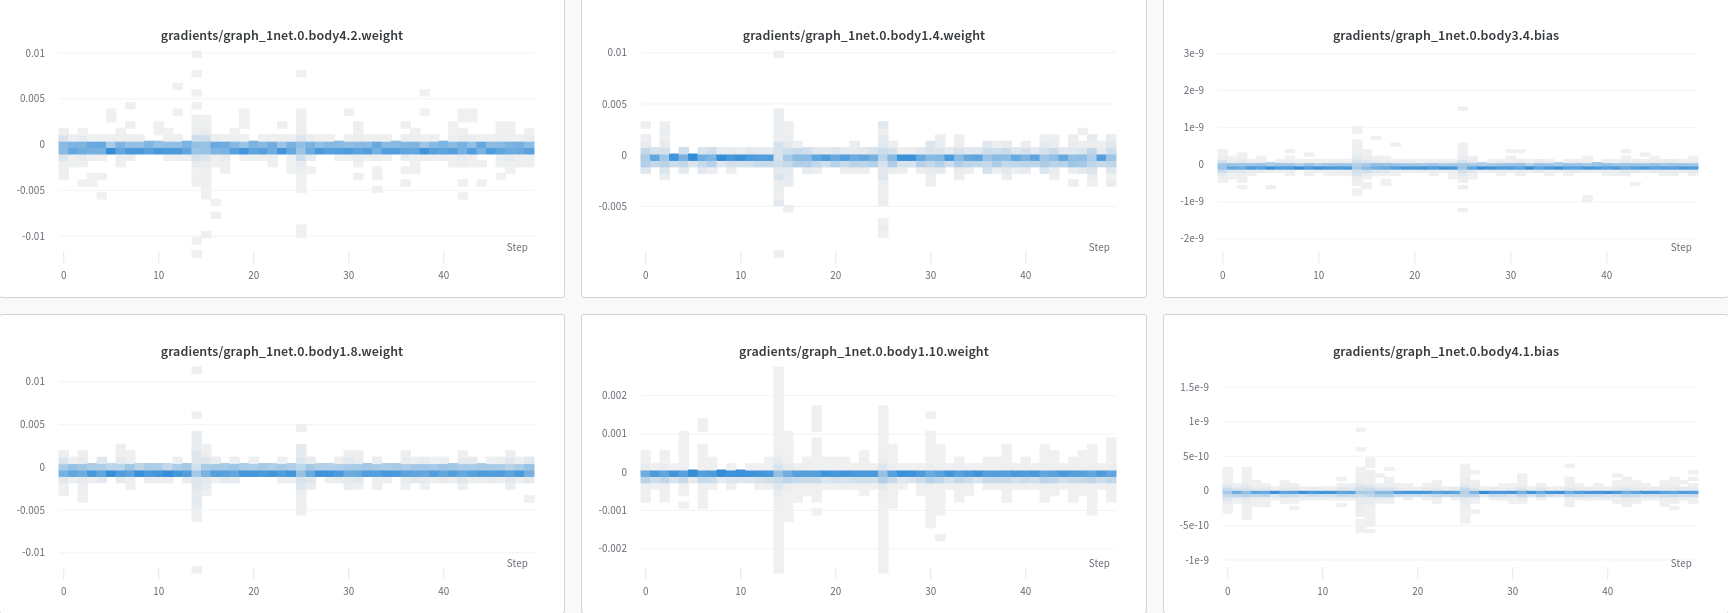

In [45]:
path=os.path.join(os.getcwd(),'plots_shanghai','gradients.png')
img=Image.open(path)
img

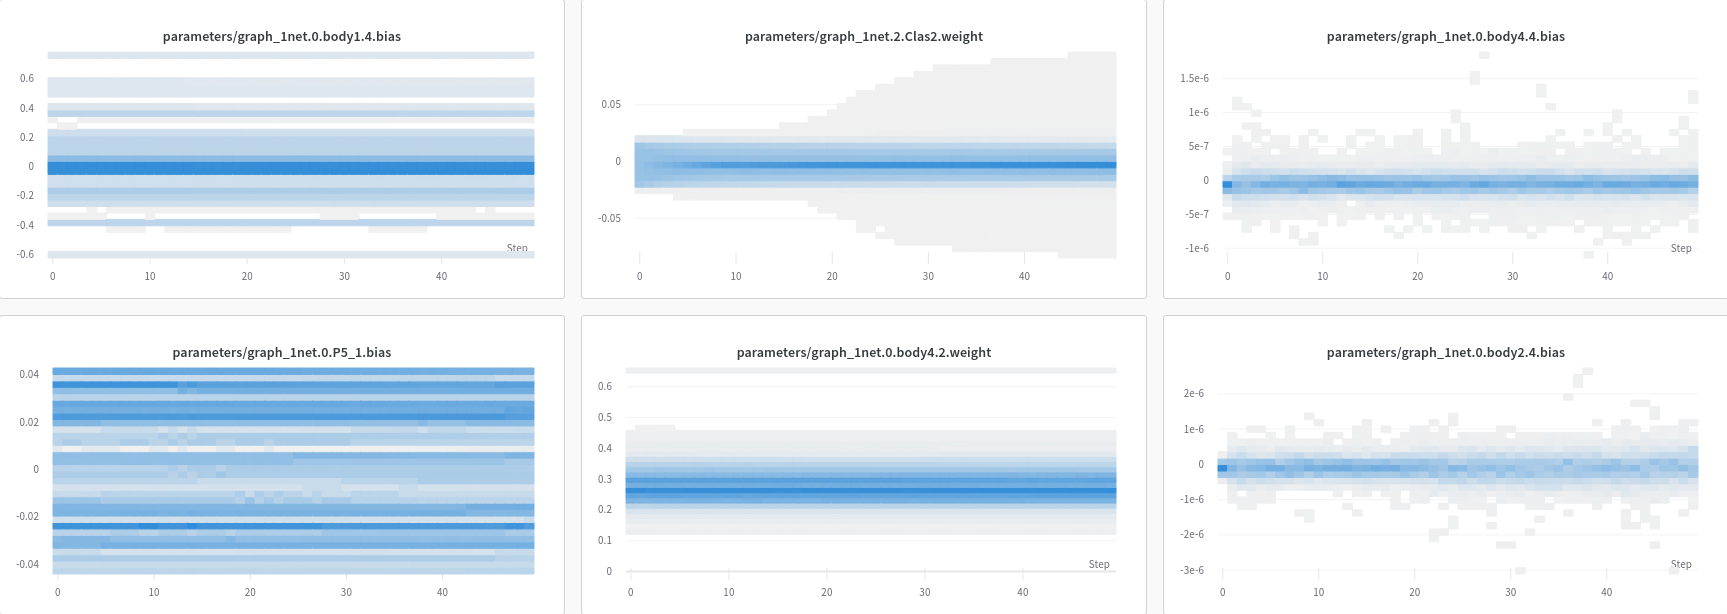

In [46]:
path=os.path.join(os.getcwd(),'plots_shanghai','feature_maps.png')
img=Image.open(path)
img

**summary table after 50 epochs for the best model according to validation MAE**

In [47]:
dict_summary={'train loss':[1.1726],'train mae':[2.648],'train_mse':[7.341],'val_loss':[5.356],'val_mae':[135.63],'val_mse':[245.01]}
pd.DataFrame(dict_summary)

,train loss,train mae,train_mse,val_loss,val_mae,val_mse
0,1.1726,2.648,7.341,5.356,135.63,245.01


In [48]:
#paper results on a test set

pd.DataFrame({'test_mae':[52.74],'test_mse':[85.06]})

,test_mae,test_mse
0,52.74,85.06


**qualitative results on images taken from the validation set**

here we show the predictions on specific test images to show the behavior of the model

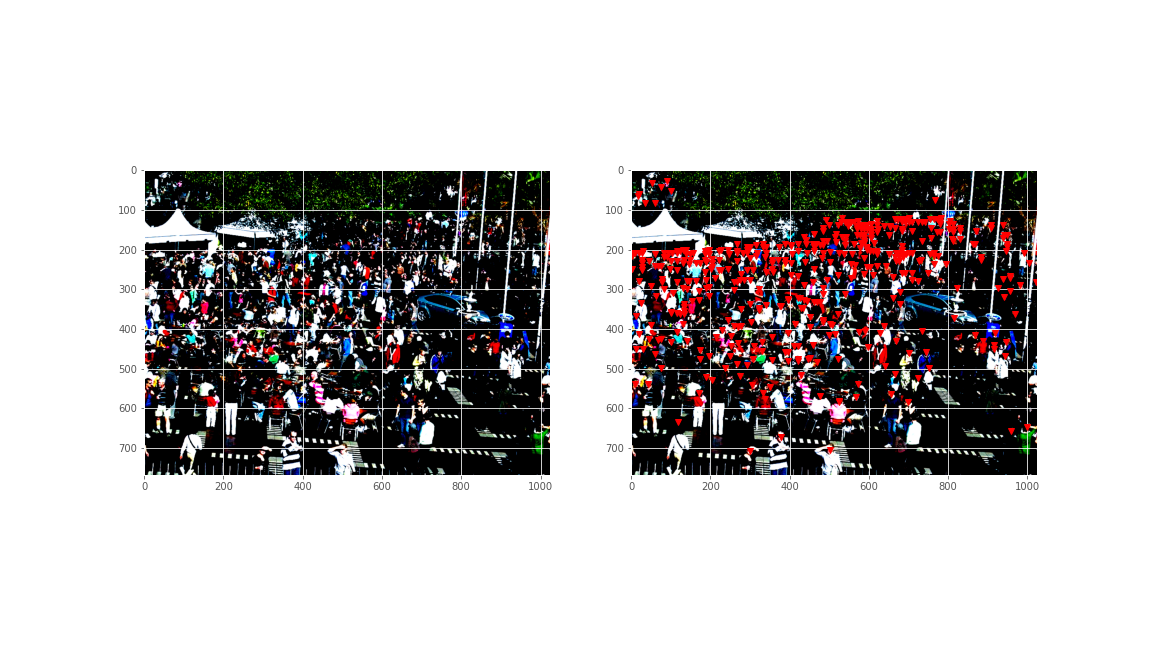

In [49]:
indexes=[1,10,100,150]
path=os.path.join(os.getcwd(),'plots_shanghai',f'points_predictions_shanghai_{indexes[0]}.png')
img=Image.open(path)
img

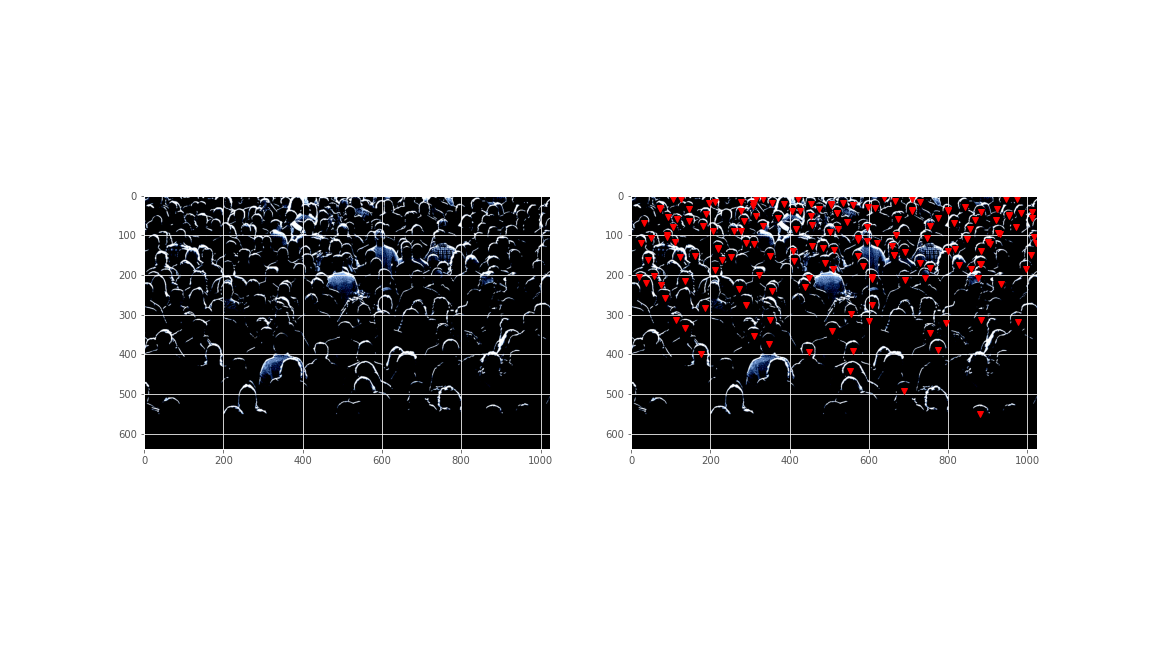

In [50]:
path=os.path.join(os.getcwd(),'plots_shanghai',f'points_predictions_shanghai_{indexes[1]}.png')
img=Image.open(path)
img

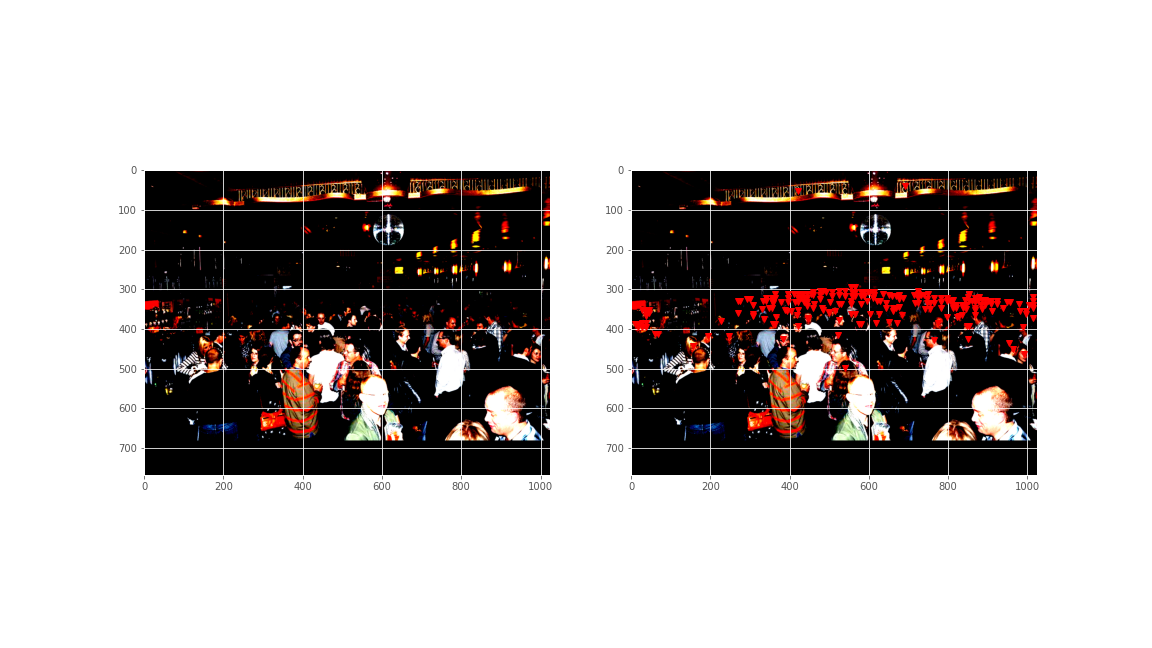

In [51]:
path=os.path.join(os.getcwd(),'plots_shanghai',f'points_predictions_shanghai_{indexes[2]}.png')
img=Image.open(path)
img

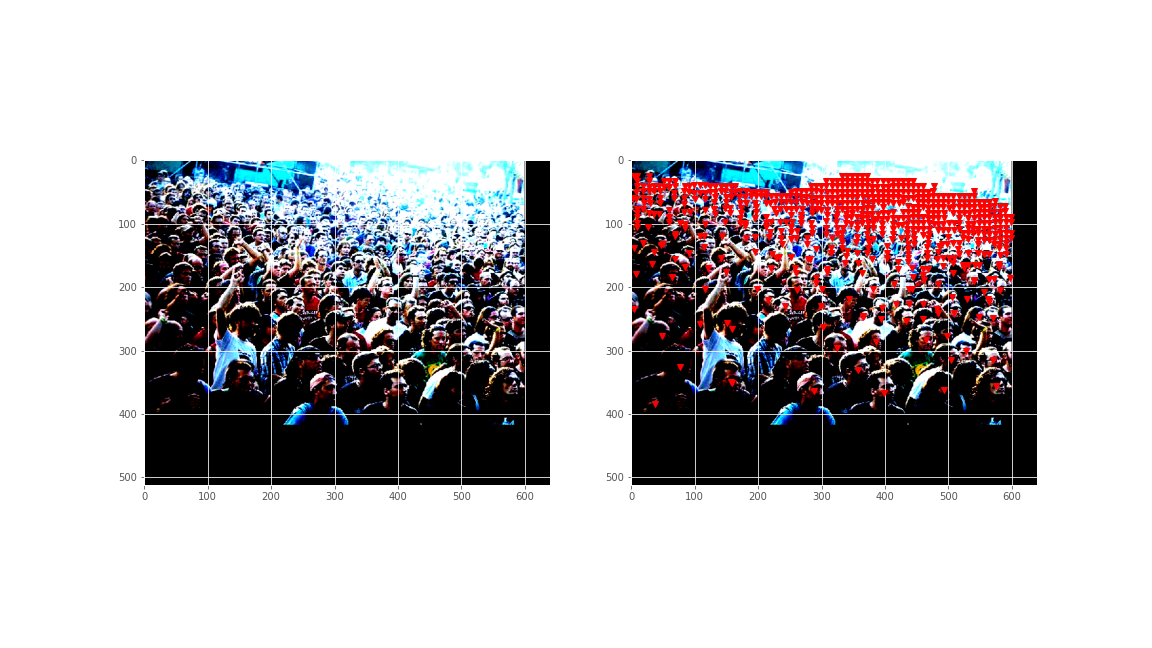

In [52]:
path=os.path.join(os.getcwd(),'plots_shanghai',f'points_predictions_shanghai_{indexes[3]}.png')
img=Image.open(path)
img

#### GRID SEARCH ####

**SHANGHAI GRID**

| lambda1 | lambda2 | tau  | Backbone LR | other LR | Weight Decay | trainLoss | trainMAE | trainMSE | ValLoss | ValMae | ValMSE |
|---------|---------|------|-------------|----------|--------------|-----------|----------|----------|---------|--------|--------|
| 0.60    | 0.0002  | 0.05 | 1e-5        | 1e-4     | 1e-5         | 2,03      | 8.11     | 15.02    | 7.68    | 205.17 | 318.77 |
| 0.5     | 0.0004  | 0.05 | 1e-5        | 1e-4     | 1e-5         | 1,93      | 10.14    | 20.01    | 8.08    | 191.69 | 302.87 |
| 0.5     | 0.0002  | 0.15 | 1e-5        | 1e-4     | 1e-5         | 2,80      | 13.46    | 41.94    | 9.49    | 427.96 | 551.22 |
| 0.4     | 1e-2    | 5e-3 | 0           | 1e-5     | 1e-5         | 11.6      | 12.60    | 20.20    | 125.0   | 381.80 | 518.70 |
| 0.4     | 1e-2    | 5e-3 | 1e-6        | 1e-5     | 1e-5         | 16.03     | 11.48    | 13.51    | 96.87   | 354.01 | 498.20 |
| 0.5     | 0.0002  | 0.05 | 1e-5        | 1e-4     | 1e-5         | 1.17      | 2.65     | 7.34     | 5.36    | 135.63 | 245.01 |

**MALL GRID**

| lambda 1 | lambda 2 | tau  | backbone lr | other lr | weight  decay | Train loss | train MAE | train MSE | val loss | val MAE | val MSE |
|----------|----------|------|-------------|----------|---------------|------------|-----------|-----------|----------|---------|---------|
| 0.5      | 2e-4     | 5e-2 | 1e-4        | 1e-4     | 1e-3          | 1,5977     | 2,892     | 1,885     | 4,29     | 33,29   | 33,77   |
| 0.6      | 4e-4     | 5e-2 | 1e-5        | 1e-4     | 1e-5          | 1,4240     | 0,3542    | 0,7556    | 6,1365   | 5       | 25      |
| 0.4      | 1e-2     | 5e-3 | 0           | 1e-5     | 1e-5          | 398,14     | 1,79      | 2,77      | 86,5     | 33,29   | 33,77   |

# COMMENTS #

*   The model learns slower on the Shanghai Dataset as we can see in the validation metrics, where the mae and mse stay constant in the first few epochs.
This is due to the fact that there is more variance in the shanghai dataset, therefore the model needs more epochs to achieve better results on the validation / to generalize.
Instead in the MALL dataset we have images that are more similar to each other and the dataset itself is bigger.
*   Increasing the regularization (the weight decay) worsens the performance on the validation.
*   It's better to have a smaller learning rate on the backbone rather than having it completely frozen
*   A smaller Tau (<0.1), which is the weight on the distance error between prediction and ground truth, is necessary for the model to learn, otherwise the model ignore the cost on the classes and performs badly.
*   Our implementation using the hyperparameters suggested by the paper gives worse results then the ones in the paper (ours: 135.65 theirs: 52.74) probably because they train for more epochs (ours: 50 theirs: 3500) and do some other (not well documented) operations on the pyramid features.
*   For the MALL dataset we don't have a reference point but the MAE and MSE that we got with the same parameters seem pretty good in light of the qualitative results shown above.

# WORK DIVISION #
Eugenio Baldo:
  Main (This Notebook)
Simone Boesso:
  Losses
  Anchor Points
Antonio Waraich:
  Data Loaders
  Backbone
  Branches

Even though these section were worked upon on the people listed above, everyone has collaborated on the entire code, especially for debugging.

The original code was used only for the matcher and the parts of Data Loader and Backbone, and only to fix our own previous implementation.